# Prerequisite: start the cluster

To use this notebook, we need an A100 VM and a TPU v5litepod-8 VM.
Both VMs should be reachable via IP address to each other.
This notebook is run on the A100 VM, which is also the ray head node.

Starting the head node:

```sh
ray start --head --port=6379
```

Joining the ray cluster from the TPU VM:

```sh
ray start --address=$GPU_IP:6379
```

In [1]:
import ray

ray.init()

2025-04-29 02:23:47,792	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.128.0.32:6379...
2025-04-29 02:23:47,806	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.14
Ray version:,2.44.1
Dashboard:,http://127.0.0.1:8265


In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader, default_collate
from torchvision import datasets, models, tv_tensors

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

import random

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Look at our training data

In [3]:
from datasets import load_dataset

def load_raw_dataset(split):
  dataset = load_dataset("flwrlabs/celeba", split=split, trust_remote_code=True, cache_dir='cache')
  return dataset.with_format("torch")

train = load_raw_dataset("train")
test = load_raw_dataset("test")
valid = load_raw_dataset("valid")

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

In [4]:
train_set = train.unique('celeb_id') # type: ignore
test_set = test.unique('celeb_id') # type: ignore
valid_set = valid.unique('celeb_id') # type: ignore
print(f"Train set: {len(train_set)}")
print(f"Test set: {len(test_set)}")
print(f"Valid set: {len(valid_set)}")
print(f"Total unique IDs: {len(set(train_set) | set(test_set) | set(valid_set))}")

Train set: 8192
Test set: 1000
Valid set: 985
Total unique IDs: 10177


Problem: there is no label overlap between train/test/valid sets.

We can't use the validation set to validate accuracy because it contains
completely unseen labels.

For the purpose of this specific convergence test, we'll do our own split
such that the same labels show up in both train and test sets.

In [5]:
from data_util import download_dataset_custom_split

train_dataset, test_dataset, NUM_CLASSES = download_dataset_custom_split()

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Concatenating datasets...


202599it [17:11, 196.35it/s]


Found 10177 unique celebrity IDs
Creating train/test splits...
Train indices: 159267, Test indices: 43288
Creating train dataset
Creating test dataset
Number of classes: 10177
Train set size: 159267
Test set size: 43288


In [7]:
from tqdm import tqdm

print("Preparing dataset loader...")
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, shuffle=False)  # type: ignore

# Enumerate train loader to find number of unique labels
train_unique_labels = set()
for batch in tqdm(train_loader):
    labels = batch['label']
    train_unique_labels.update(set(labels.flatten().numpy().tolist()))
print(f"Number of unique labels in train loader: {len(train_unique_labels)}")
# Enumerate test loader to find number of unique labels
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=4, shuffle=False)  # type: ignore
test_unique_labels = set()
for batch in tqdm(test_loader):
    labels = batch['label']
    test_unique_labels.update(set(labels.flatten().numpy().tolist()))
print(f"Number of unique labels in test loader: {len(test_unique_labels)}")

Preparing dataset loader...


100%|██████████| 2489/2489 [05:43<00:00,  7.25it/s]


Number of unique labels in train loader: 10133


100%|██████████| 677/677 [01:35<00:00,  7.12it/s]

Number of unique labels in test loader: 10133


In [10]:
assert train_unique_labels == test_unique_labels

In [12]:
sorted(list(train_unique_labels))[-10:], sorted(list(test_unique_labels))[-10:]

([10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176],
 [10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176])

In [ ]:
from actors import get_gpu_actor

gpu_actor = get_gpu_actor()
print(ray.get(gpu_actor.print_model_architecture.remote()))
print(ray.get(gpu_actor.get_cwd.remote()))

GPU Actor (PID: 2949370) using cuda (NVIDIA A100-SXM4-80GB)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

## Convergence test

Now let's run a proper training run with:

- Learning rate: `1e-4` (smaller than the existing `1e-3`)
- Batch size: 512 (unchanged)
- Training set: `flwrlabs/celeba/train`
- Validation set (used to compute validation accuracy): `flwrlabs/celeba/valid`
- Measure:
  - val-loss
  - val-top1-acc
- Final evaluation: `flwrlabs/celeba/test`

If TPU is materially worse on val-top1-acc with same LR/batchsize, that's a
material datapoint and we probably want to bring it back to the TPU team to see
if that's also expected behavior.

In [ ]:
from tqdm import tqdm
from actors import get_tpu_actor, reset_all_actors, ActorResetter

actor_resetter = ActorResetter(gpu_actor=gpu_actor, num_classes=8192)
gpu_actor, tpu_actor = reset_all_actors(gpu_actor, tpu_actor=None, actor_resetter=actor_resetter)
ray.get(tpu_actor.set_matmul_precision.remote('default'))
ray.get(gpu_actor.init_optimizer.remote(1e-4))
ray.get(tpu_actor.init_optimizer.remote(1e-4))

BATCH_SIZE = 512
training_split = 'train'

gpu_losses = []
tpu_losses = []
gpu_validation_metrics = []
tpu_validation_metrics = []
for epoch in range(40):
  gpu_stream = gpu_actor.run_training_epoch.remote(batch_size=BATCH_SIZE, training_split=training_split, shuffle=True, run_validation=True, dataloader_seed=epoch)
  tpu_stream = tpu_actor.run_training_epoch.remote(batch_size=BATCH_SIZE, training_split=training_split, shuffle=True, run_validation=True, dataloader_seed=epoch)
  progress = tqdm(zip(gpu_stream, tpu_stream, strict=True))
  gpu_loss = None
  tpu_loss = None
  for gpu_stuff, tpu_stuff in progress:
    gpu_stuff = ray.get(gpu_stuff)
    tpu_stuff = ray.get(tpu_stuff)
    if isinstance(gpu_stuff, tuple) and isinstance(tpu_stuff, tuple):
      i, gpu_loss, gpu_data_hash = gpu_stuff
      j, tpu_loss, tpu_data_hash = tpu_stuff
      if i != j:
        raise ValueError("Iteration numbers do not match between GPU and TPU actors!")
      if gpu_data_hash != tpu_data_hash:
        raise ValueError("Data hashes do not match between GPU and TPU actors!")
      gpu_losses.append(gpu_loss)
      tpu_losses.append(tpu_loss)
      progress.set_postfix_str(f"Epoch {epoch} Iter {i} | GPU Loss: {gpu_loss:.6f} | TPU Loss: {tpu_loss:.6f}")
    elif isinstance(gpu_stuff, dict) and isinstance(tpu_stuff, dict):
      gpu_validation_metrics.append(gpu_stuff)
      tpu_validation_metrics.append(tpu_stuff)
      progress.set_postfix_str(f"Epoch {epoch} | GPU Loss: {gpu_loss:.6f} | TPU Loss: {tpu_loss:.6f} | GPU Validation: {gpu_stuff} | TPU Validation: {tpu_stuff}")
    else:
      raise ValueError(f"Unexpected data types from GPU and TPU actors! {type(gpu_stuff)}, {type(tpu_stuff)}")


GPU Actor (PID: 2949846) using cuda (NVIDIA A100-SXM4-80GB)
TPU Actor (PID: 206715) using xla:0 (v5litepod-8)
✅ GPU and TPU models have identical state dicts


318it [34:40,  6.54s/it, Epoch 0 | GPU Loss: 8.336626 | TPU Loss: 8.362222 | GPU Validation: {'avg_valid_loss': 9.428862596169497, 'top1_accuracy': 5.033472592741732e-05, 'top5_accuracy': 0.00015100417778225197} | TPU Validation: {'avg_valid_loss': 9.407790477459248, 'top1_accuracy': 0.0, 'top5_accuracy': 0.0002516736296370866}]
318it [08:48,  1.66s/it, Epoch 1 | GPU Loss: 7.291451 | TPU Loss: 7.309406 | GPU Validation: {'avg_valid_loss': 9.98862606439835, 'top1_accuracy': 0.00010066945185483464, 'top5_accuracy': 0.0004026778074193386} | TPU Validation: {'avg_valid_loss': 9.876938086289625, 'top1_accuracy': 0.00015100417778225197, 'top5_accuracy': 0.0006040167111290079}]
318it [08:51,  1.67s/it, Epoch 2 | GPU Loss: 6.291717 | TPU Loss: 6.292647 | GPU Validation: {'avg_valid_loss': 10.550289594210112, 'top1_accuracy': 0.00010066945185483464, 'top5_accuracy': 0.00045301253334675595} | TPU Validation: {'avg_valid_loss': 10.441532550713955, 'top1_accuracy': 5.033472592741732e-05, 'top5_acc

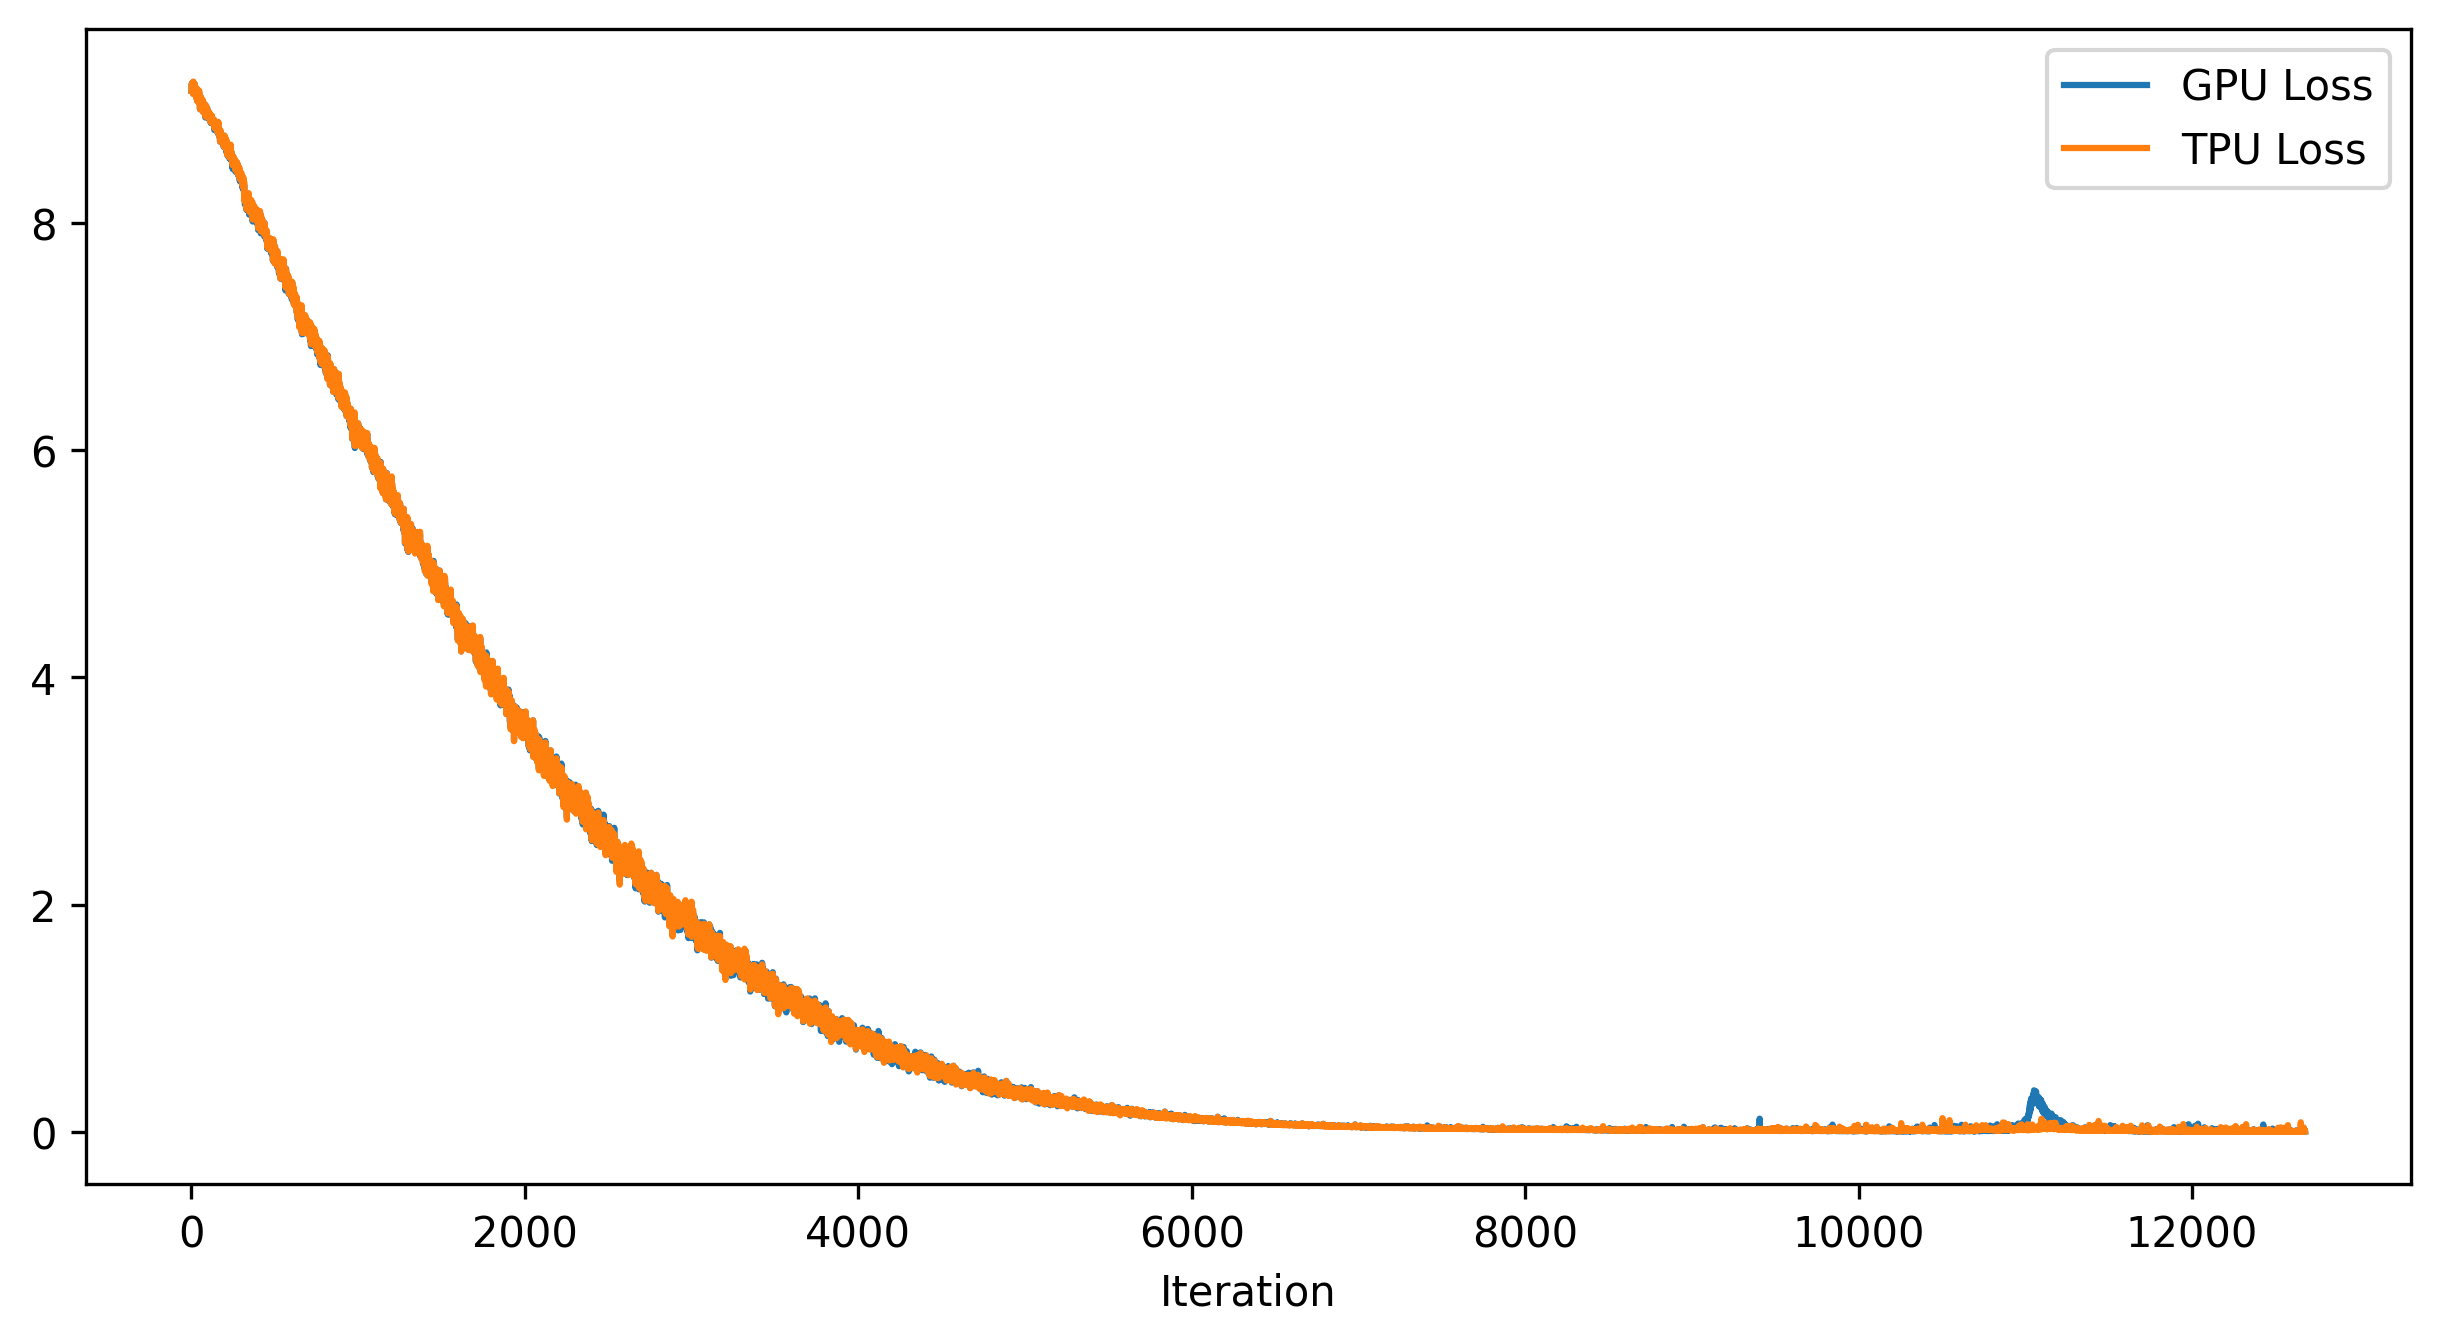

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(gpu_losses, label='GPU Loss')
plt.plot(tpu_losses, label='TPU Loss')
plt.xlabel('Iteration') 
plt.legend()
plt.show()

In [ ]:
import os
import json

# Save the gpu and tpu losses to `outputs/` in JSON format.
os.makedirs("outputs/convergence/lr-1e-4", exist_ok=True)

with open("outputs/convergence/lr-1e-4/gpu_losses.json", "w") as f:
  json.dump(gpu_losses, f)

with open("outputs/convergence/lr-1e-4/tpu_losses.json", "w") as f:
  json.dump(tpu_losses, f)

with open("outputs/convergence/lr-1e-4/gpu_validation_metrics.json", "w") as f:
  json.dump(gpu_validation_metrics, f)

with open("outputs/convergence/lr-1e-4/tpu_validation_metrics.json", "w") as f:
  json.dump(tpu_validation_metrics, f)

### Appendix: test LR=1e-3

See if this will cause loss spikes.

In [ ]:
from tqdm import tqdm
actor_resetter = ActorResetter(gpu_actor=gpu_actor, num_classes=8192)
gpu_actor, tpu_actor = reset_all_actors(gpu_actor, tpu_actor=None, actor_resetter=actor_resetter)
ray.get(tpu_actor.set_matmul_precision.remote('default'))
ray.get(gpu_actor.init_optimizer.remote(1e-3))
ray.get(tpu_actor.init_optimizer.remote(1e-3))

BATCH_SIZE = 512
training_split = 'train'

gpu_losses = []
tpu_losses = []
gpu_validation_metrics = []
tpu_validation_metrics = []
for epoch in range(40):
  gpu_stream = gpu_actor.run_training_epoch.remote(batch_size=BATCH_SIZE, training_split=training_split, shuffle=True, run_validation=True, dataloader_seed=epoch)
  tpu_stream = tpu_actor.run_training_epoch.remote(batch_size=BATCH_SIZE, training_split=training_split, shuffle=True, run_validation=True, dataloader_seed=epoch)
  progress = tqdm(zip(gpu_stream, tpu_stream, strict=True))
  gpu_loss = None
  tpu_loss = None
  for gpu_stuff, tpu_stuff in progress:
    gpu_stuff = ray.get(gpu_stuff)
    tpu_stuff = ray.get(tpu_stuff)
    if isinstance(gpu_stuff, tuple) and isinstance(tpu_stuff, tuple):
      i, gpu_loss, gpu_data_hash = gpu_stuff
      j, tpu_loss, tpu_data_hash = tpu_stuff
      if i != j:
        raise ValueError("Iteration numbers do not match between GPU and TPU actors!")
      if gpu_data_hash != tpu_data_hash:
        raise ValueError("Data hashes do not match between GPU and TPU actors!")
      gpu_losses.append(gpu_loss)
      tpu_losses.append(tpu_loss)
      progress.set_postfix_str(f"Epoch {epoch} Iter {i} | GPU Loss: {gpu_loss:.6f} | TPU Loss: {tpu_loss:.6f}")
    elif isinstance(gpu_stuff, dict) and isinstance(tpu_stuff, dict):
      gpu_validation_metrics.append(gpu_stuff)
      tpu_validation_metrics.append(tpu_stuff)
      progress.set_postfix_str(f"Epoch {epoch} | GPU Loss: {gpu_loss:.6f} | TPU Loss: {tpu_loss:.6f} | GPU Validation: {gpu_stuff} | TPU Validation: {tpu_stuff}")
    else:
      raise ValueError(f"Unexpected data types from GPU and TPU actors! {type(gpu_stuff)}, {type(tpu_stuff)}")


GPU Actor (PID: 3400624) using cuda (NVIDIA A100-SXM4-80GB)
TPU Actor (PID: 1237365) using xla:0 (v5litepod-8)
✅ GPU and TPU models have identical state dicts


318it [08:53,  1.68s/it, Epoch 0 | GPU Loss: 8.948339 | TPU Loss: 8.800580 | GPU Validation: {'avg_valid_loss': 9.057168300335224, 'top1_accuracy': 0.0, 'top5_accuracy': 0.0} | TPU Validation: {'avg_valid_loss': 9.17905452923897, 'top1_accuracy': 0.00010066945185483464, 'top5_accuracy': 0.0002516736296370866}]
318it [08:41,  1.64s/it, Epoch 1 | GPU Loss: 8.285970 | TPU Loss: 7.300141 | GPU Validation: {'avg_valid_loss': 9.798181142562475, 'top1_accuracy': 0.0, 'top5_accuracy': 0.0002013389037096693} | TPU Validation: {'avg_valid_loss': 11.10123959565774, 'top1_accuracy': 0.00015100417778225197, 'top5_accuracy': 0.0005536819852015905}]
318it [08:50,  1.67s/it, Epoch 2 | GPU Loss: 7.101722 | TPU Loss: 5.402316 | GPU Validation: {'avg_valid_loss': 11.930481837346004, 'top1_accuracy': 0.00010066945185483464, 'top5_accuracy': 0.0002516736296370866} | TPU Validation: {'avg_valid_loss': 14.824173218164688, 'top1_accuracy': 0.0002013389037096693, 'top5_accuracy': 0.0010570292444757638}]
318it 

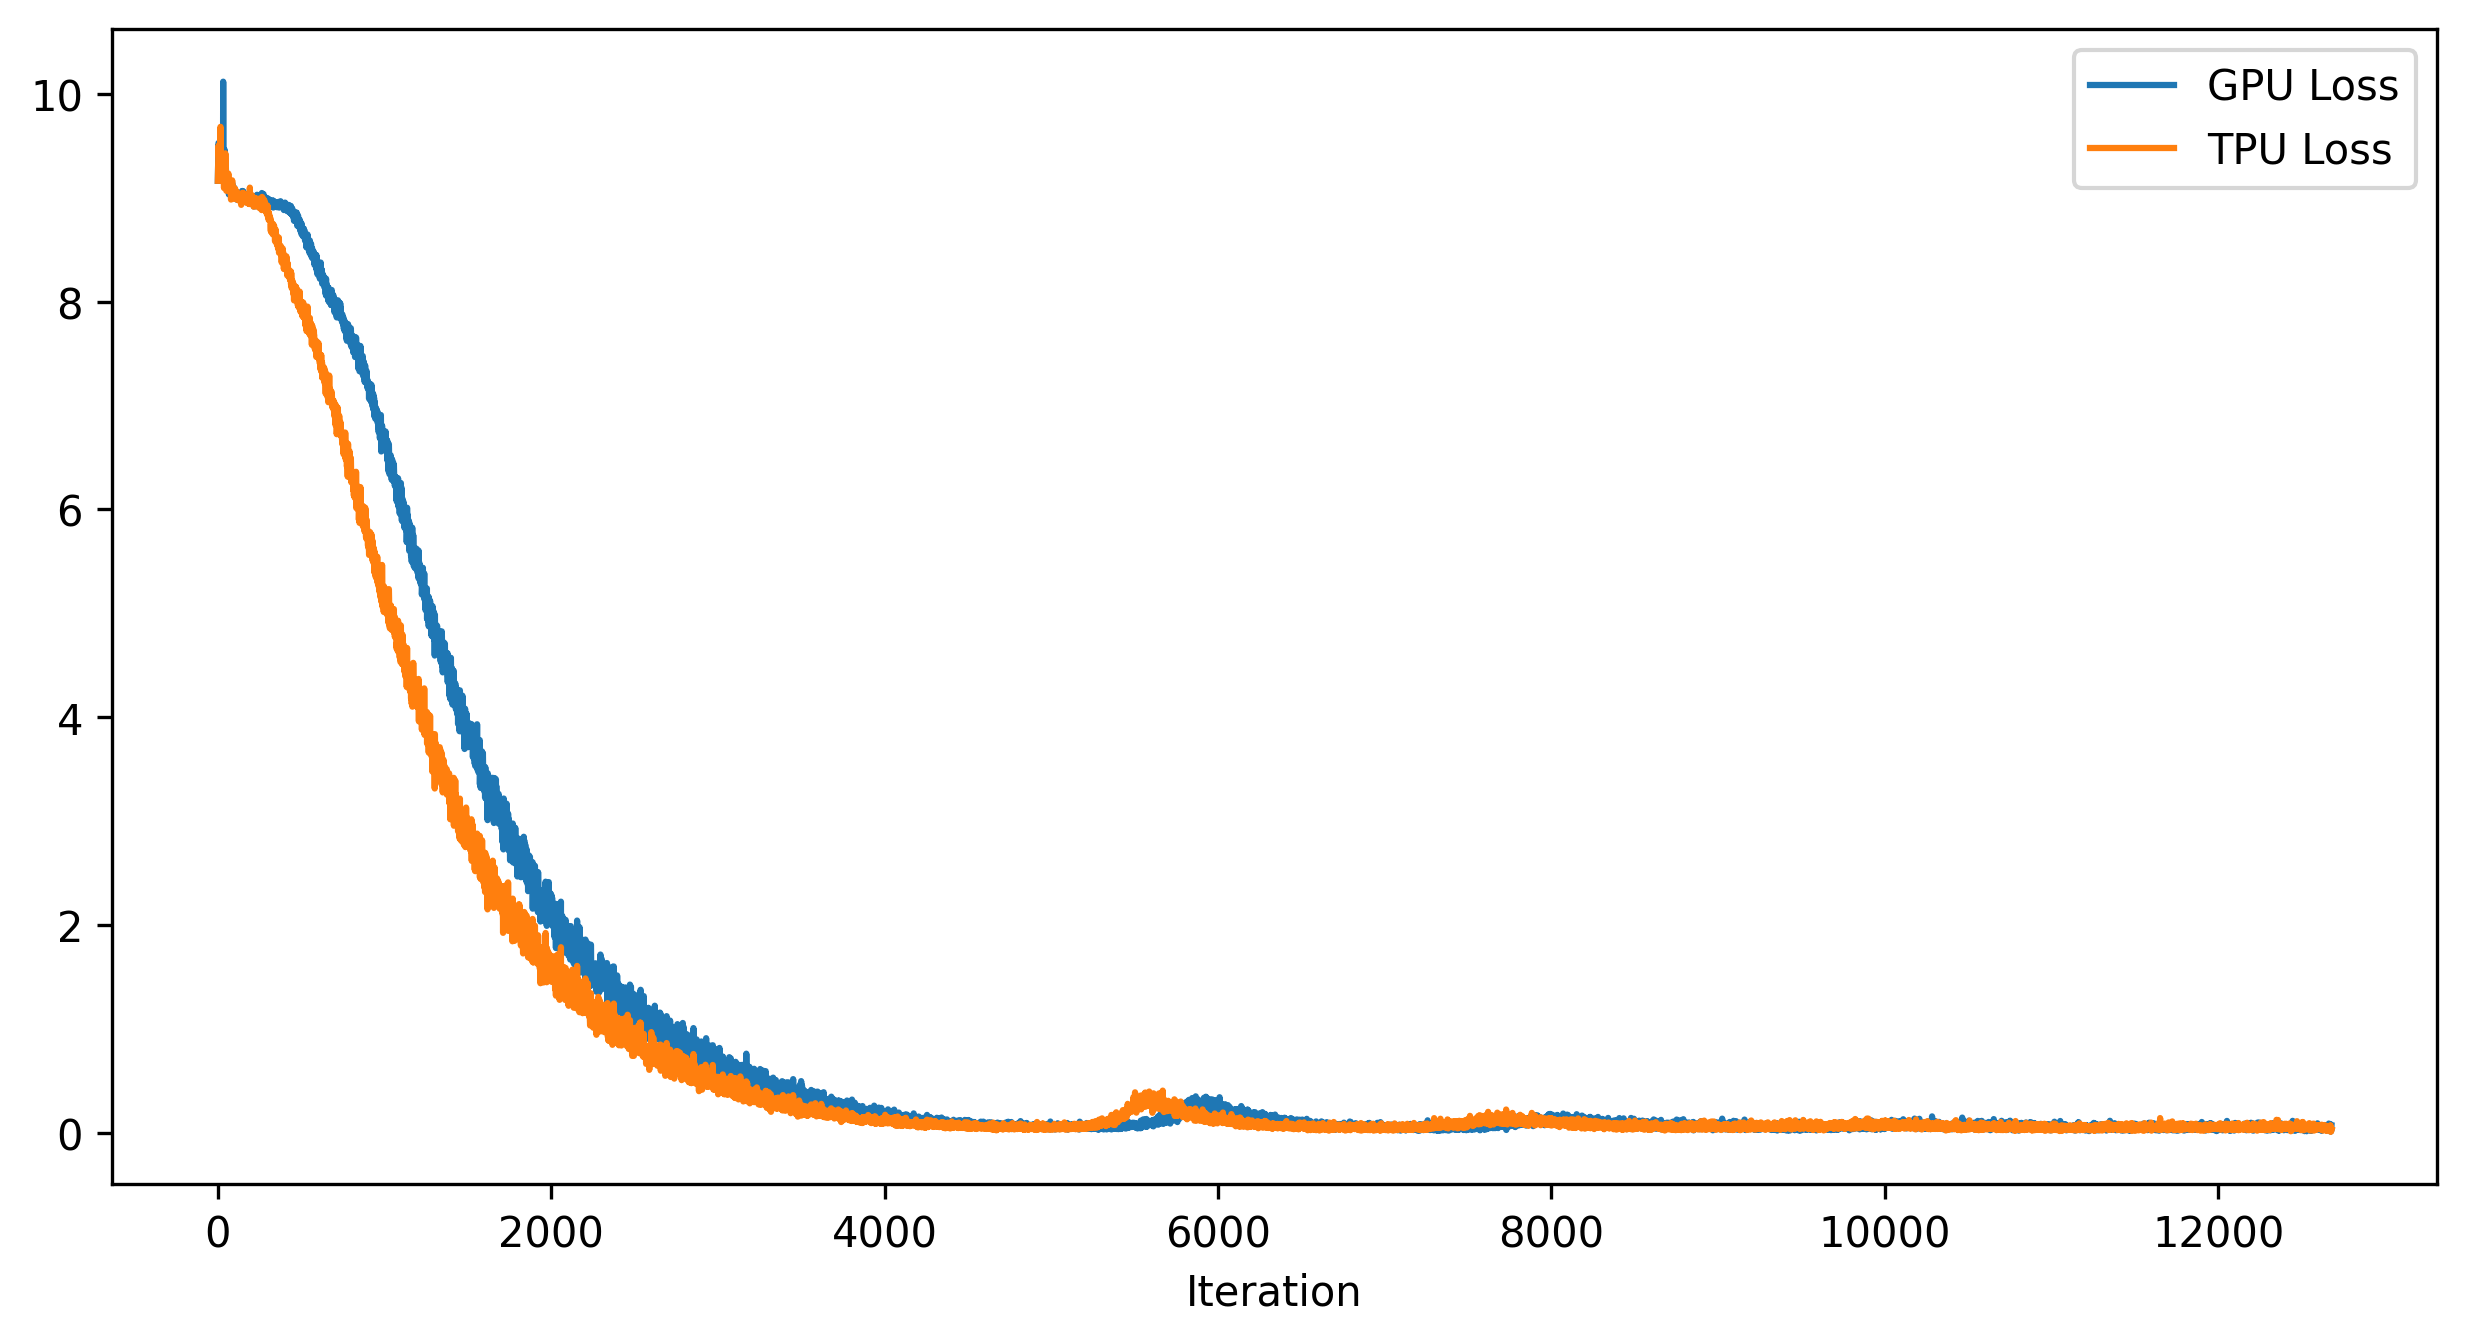

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(gpu_losses, label='GPU Loss')
plt.plot(tpu_losses, label='TPU Loss')
plt.xlabel('Iteration') 
plt.legend()
plt.show()

In [ ]:
import os
import json

# Save the gpu and tpu losses to `outputs/` in JSON format.
os.makedirs("outputs/convergence/lr-1e-3", exist_ok=True)

with open("outputs/convergence/lr-1e-3/gpu_losses.json", "w") as f:
  json.dump(gpu_losses, f)

with open("outputs/convergence/lr-1e-3/tpu_losses.json", "w") as f:
  json.dump(tpu_losses, f)

with open("outputs/convergence/lr-1e-3/gpu_validation_metrics.json", "w") as f:
  json.dump(gpu_validation_metrics, f)

with open("outputs/convergence/lr-1e-3/tpu_validation_metrics.json", "w") as f:
  json.dump(tpu_validation_metrics, f)

TODO: investigate label drift